<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab1/LAB01-DataMining-Joe%20Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

 ### Team:  
Joseph Schueder,
Armando Vela,
Daniel Clark,
Jeff Washburn

### Load Python Packages

In [0]:
# Import necessary python packages
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load Data from github

We will be querying the 2019 data and subsetting a random sample of 400,000 rows within the 2 million sales that happened that year for our analysis

In [10]:
# Read csv from disk
#df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 100000)
#df =  pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)

# read csv from github directly
url_dataset = 'https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/iowa_subset_2019_400k_random_rows.csv?raw=true'
#df = pd.read_csv(url_dataset, nrows=50000)
df = pd.read_csv(url_dataset)

# verify data read in
df.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241.0,POINT (-91.565517 41.672672),52.0,JOHNSON,1092100.0,Imported Distilled Spirit Specialty,293,JINRO AMERICA INC,989215,Jinro Chamisul Grapefruit Soju,20,375,3.85,5.78,20,115.60,7.50,1.98
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317.0,POINT (-93.570489 41.607817),77.0,POLK,1091300.0,Neutral Grain Spirits Flavored,346,OLE SMOKY DISTILLERY LLC,86739,Ole Smoky Apple Pie Moonshine 70prf Mini,8,50,8.75,13.13,1,13.13,0.05,0.01
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302.0,NaN,57.0,LINN,1042100.0,Imported Dry Gins,35,BACARDI USA INC,28233,Bombay Sapphire Gin,12,1000,16.50,24.75,6,148.50,6.00,1.58
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807.0,POINT (-90.548919 41.55678100000001),82.0,SCOTT,1011300.0,Single Barrel Bourbon Whiskies,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,21.17,31.76,24,762.24,18.00,4.75
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503.0,POINT (-95.825137 41.242732),78.0,POTTAWATTA,1901200.0,Special Order Items,285,Charles Jacquin Et Cie,902291,SOOH Bartenders Bananas Over You,6,1750,9.31,13.97,12,167.64,21.00,5.54


### Columns and Descriptions
Below are the 24 columns found in the data set along with description of each.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 24 columns):
invoice_and_item_number    400000 non-null object
date                       400000 non-null object
store_number               400000 non-null int64
store_name                 400000 non-null object
address                    399215 non-null object
city                       399215 non-null object
zip_code                   399215 non-null float64
store_location             362936 non-null object
county_number              399215 non-null float64
county                     399215 non-null object
category                   398960 non-null float64
category_name              398960 non-null object
vendor_number              400000 non-null int64
vendor_name                400000 non-null object
item_number                400000 non-null int64
item_description           400000 non-null object
pack                       400000 non-null int64
bottle_volume_ml           400000 non-nu

Detailed Description of each field - referenced from the [data.iowa.gov](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) site that describes the dataset

*   invoice_and_item_number (text) - Invoice and item associated with the liquor order.  This is unique identifier 
*   date (date) - Date of when the order was placed
*   store_number (int) - Unique number assigned to the retail store that placed the order
*   store_name (text) - Name of the retail store that placed the order
*   address (text) - Address of the retail store that placed the order
*   city (text) - City of the retail store that placed the order
*   zip_code (float) - Zip code of the retail store that placed the order
*   store_location (text) - Lat/Long of retail store that placed the order
*   county_number (float) - Iowa county number for which the retail store that placed the order resides
*   county (text) - County name for which the retail store is located that placed the order
*   category (float) - Category code for the liquor that was ordered
*   category_name (text) - Category of the liquor that was ordered
*   vendor_number (int) - The vendor number of the company for the brand of liquor ordered 
*   vendor_name (text) - The vendor name of the company for the brand of liquor ordered
*   item_number (int) - Item number for individual liquor product ordered
*   item_description (text) - Description of the liquor item ordered
*   pack (int) - The number of bottles in a case for the liquor ordered
*   bottle_volume_ml (int) - Volume of each liquor bottle ordered in milliliters
*   state_bottle_cost (float) - The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
*   state_bottle_retail (float) - The amount the store paid for each bottle of liquor ordered
*   bottles_sold (int) - Number of bottles of liquor ordered by the retail store
*   sale_dollars (float) - Total cost of liquor ordered (bottles_sold * state_bottle_retail)
*   volume_sold_liters (float) - Total volume of liquor ordered in liters (bottle_volume_ml * bottles_sold / 1000)
*   volume_sold_gallons (float) - Total volume of liquor ordered in gallons (bottle_volume_ml * bottles_sold / 3785.411784)





## Data Quality  
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

In [12]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

### Data Cleaning

In our data cleaning step, we need to perform a few specific data cleaning operations to:
1.   Convert our features to the correct continuous, ordinal and categorical features.
  * Replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model

2.   Address the missing values
  *   The data has a few fields that are missing data. These missing values primarily are centered around location related information and liquor categorization. Some cleanup will be done by referencing external sources with store name and item description to infer address information. 
  *   Replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats.

3.  Check on duplicates.  
4.  Create a category that simplifies our alcohol categories to specific genres like whiskey, vodka, tequila, etc.
5.   Categorize our store locations into a few easily discernible buckets.
6.   Create a month and date column for opportunities to time and date analysis.
7.   Convert the variable "bottles_sold" into ordinal features so they register as an integer value in our models  
8. Identify outliers and normalize them so that they don't skew our analysis and models.

Using a df.types function helps to verify this. 

In [13]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                   float64
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [0]:
df_corr = df.copy()

In [119]:
df_corr.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [120]:

# Create correlation matrix
corr_matrix = df_corr.corr().abs()
corr_matrix

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
pack,1.000000,0.583376,0.396909,0.396613,0.197974,0.044329,0.045399,0.045420,0.149088,0.111411,0.031250,0.659579,0.285858,0.097873,0.029256
bottle_volume_ml,0.583376,1.000000,0.257163,0.256866,0.050324,0.070925,0.116995,0.117054,0.244269,0.282219,0.487253,0.406372,0.026219,0.490400,0.015925
state_bottle_cost,0.396909,0.257163,1.000000,0.998987,0.094551,0.093317,0.008615,0.008617,0.274887,0.298577,0.491705,0.824341,0.269951,0.085615,0.021261
state_bottle_retail,0.396613,0.256866,0.998987,1.000000,0.094477,0.093215,0.008620,0.008622,0.274663,0.298243,0.491232,0.823560,0.269661,0.085501,0.005495
bottles_sold,0.197974,0.050324,0.094551,0.094477,1.000000,0.806402,0.852826,0.852826,0.419954,0.048674,0.083678,0.172085,0.526076,0.380934,0.004968
sale_dollars,0.044329,0.070925,0.093317,0.093215,0.806402,1.000000,0.859482,0.859482,0.474039,0.013155,0.017666,0.109463,0.394611,0.361270,0.002498
volume_sold_liters,0.045399,0.116995,0.008615,0.008620,0.852826,0.859482,1.000000,1.000000,0.371699,0.047608,0.098178,0.007940,0.360519,0.351944,0.000039
volume_sold_gallons,0.045420,0.117054,0.008617,0.008622,0.852826,0.859482,1.000000,1.000000,0.371718,0.047615,0.098212,0.007950,0.360531,0.351980,0.000039
sale_dollars_trans,0.149088,0.244269,0.274887,0.274663,0.419954,0.474039,0.371699,0.371718,1.000000,0.042377,0.008465,0.308425,0.781589,0.790142,0.006441
cost_per_liter,0.111411,0.282219,0.298577,0.298243,0.048674,0.013155,0.047608,0.047615,0.042377,1.000000,0.691285,0.220768,0.186546,0.456984,0.006487


In [0]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# courtesy of https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [122]:
to_drop

['state_bottle_retail', 'volume_sold_gallons']

Looking at our correlation matrix, we can see which measures meet our criteria of removing features that have a greater than 95% correlation. As the predictability of one feature will determine another, which will cause us to want to do a dimensionality reduction. 
In our case, we are going to remove state_bottle_retail as it correlates highly with state_bottle_cost, as well as volume_sold_gallons as it correlates perfectly with volume_sold_liters.

In [0]:
# Drop features 
df_corr = df_corr.drop(df_corr[to_drop], axis=1)

### Feature Reduction using PCA and LDA
PCA  
To run a PCA analysis, we will want to first remove some of the highly correlated variables which may throw off our analysis. This will mean we should run a correlation plot and set our correlation threshold to 0.95, which we will remove variables if exceeded. 

First, lets take a look at our Seaborn plot that we will use to run principal component analysis. To get started, we will want to create dummies for each of our categories of alcohol, so that we have a single binary under Whiskey as the sale was a whiskey drink (1) or it was not (0)

In [0]:
df_corr2 = pd.get_dummies(df['liquor_category'], drop_first=False)

df_corr = pd.concat([df_corr, df_corr2], axis = 1, sort=False)



In [125]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#drop the response variable from x
# one hot encoding to category
features = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold', 'sale_dollars_trans', 'volume_sold_liters']

X = df_corr.loc[:, features].values
# run this second line below which compiles all the features that i want to use to predict category, or the column we want to predict
#X = X.drop (category, inplace = True)
y = df_corr.loc[:, ['WHISKY']].values
#target_names = df_corr.store_parent_names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=2)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(6, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


pca: [[-8.76772443e-03  9.99901289e-01  3.74780890e-03 -3.38111153e-03
   4.65116586e-04  9.73881295e-03]
 [ 1.24510277e-02 -5.35907991e-03 -8.40892784e-03  6.24229067e-01
   7.24862636e-03  7.81044859e-01]]
lda: [[-0.00589082 -0.00095126  0.13870644 -0.00166674  0.04170408  0.00042601]]


Now what we did here was isolate our categorical variable "Whiskey" and fit a PCA and LDA model using the continuous variables remaining in the set. Using this, our model will be able to advise on how much we can explain variance using the different principal components. 
Scaling it in this way allows our model to utilize and compare all variables on the same plane. 

In [126]:
principalDf = pd.DataFrame(data = X_pca
             , columns = ['principal component 1', 'principal component 2'])

principalDf.describe()

,principal component 1,principal component 2
count,4.000000e+05,4.000000e+05
mean,2.130926e-11,1.473875e-12
std,5.578664e+02,5.748631e+01
min,-9.352922e+02,-3.959859e+01
25%,-2.101569e+02,-1.185425e+01
50%,-2.100968e+02,-9.353322e+00
75%,7.898191e+02,-1.319139e+00
max,5.040052e+03,7.504936e+03


Creating a dataframe of our principal components, we can see that there is quite a range in the values we have, from the negatives to the positives, with also a strong standard deviation. 
The mean principal component is nearly off the scale due to the effect of outliers. 

In [127]:
finalDf = pd.concat([principalDf, df_corr[['WHISKY']]], axis = 1)

finalDf.head()

,principal component 1,principal component 2,WHISKY
0,-585.208120,4.613021,0
1,-910.061786,-11.530798,0
2,39.880582,-8.851344,0
3,-209.967866,12.994968,1
4,789.958060,2.577026,0


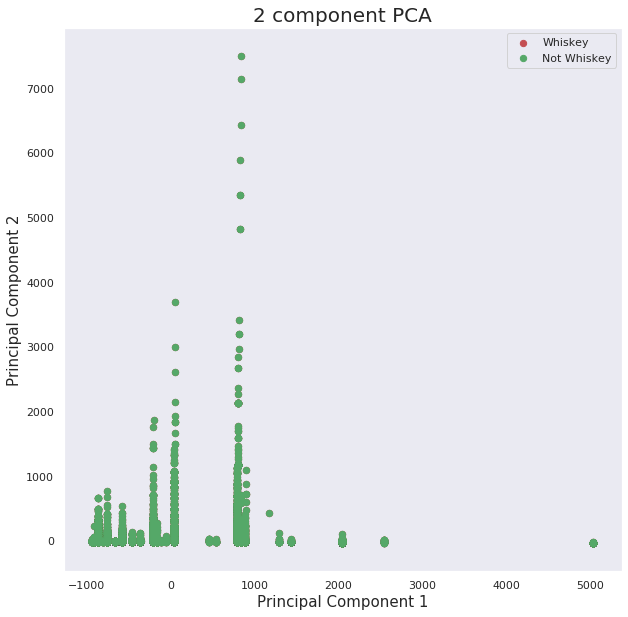

In [128]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Whiskey', 'Not Whiskey']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['WHISKY'] == 0
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()

Looking at the plot we graphed, we can see the effect of outliers and the fact that non/whiskeys have quite a presence in our chart. 
Our explained variance ratio below shows that we can explain 97% of the variance with one principal component, and less than 3% with the second principal component.

In [129]:
pca.explained_variance_ratio_

array([0.98843761, 0.01049585])

In [130]:
#lets transform our outliers to make them easier to read. 

finalDf2 = finalDf

finalDf2['principal component 1 trans'] = np.log(finalDf['principal component 1'])
finalDf2['principal component 2 trans'] = np.log(finalDf['principal component 2'])

finalDf2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,principal component 1,principal component 2,WHISKY,principal component 1 trans,principal component 2 trans
0,-585.208120,4.613021,0,NaN,1.528883
1,-910.061786,-11.530798,0,NaN,NaN
2,39.880582,-8.851344,0,3.68589,NaN
3,-209.967866,12.994968,1,NaN,2.564562
4,789.958060,2.577026,0,6.67198,0.946636


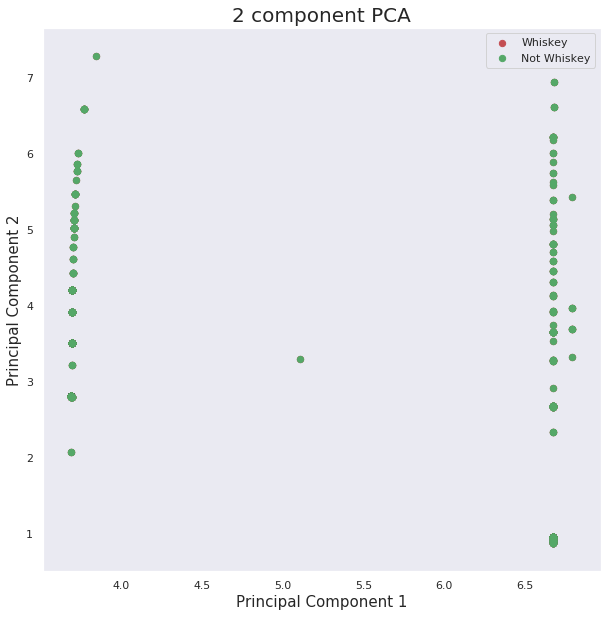

In [131]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Whiskey', 'Not Whiskey']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2['WHISKY'] == 1
    ax.scatter(finalDf2.loc[indicesToKeep, 'principal component 1 trans']
               , finalDf2.loc[indicesToKeep, 'principal component 2 trans']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()